### This notebook is for calculating the contribution of each module of the optimal parcellation to the similarity, FC modularity, SC modularity, and $\chi$, and their relation with the size of the module.

Run the cells of the notebook `04-get-xmod-and-generate-optimal-parcellation.ipynb` prior to running this notebook.

In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.plotting_functions import plot_corr
import seaborn as sns
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list
from matplotlib import colors

First, it's needed to define the connectome size, it's possible to choose between the following number of nodes: 183, 391, 568, 729, 964, 1242, 1584, 1795, 2165. But it is recommended to use the best initial parcellation (in this case 2165 nodes).

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

As we are going to study the FC and SC modularities using the average connectome matrices, it's necessary to reload/recompute them.

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


As in the previous notebooks, we equal the density in both connectomes and remove the disconnected nodes.

In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


It is necessary to define some global variables for the rest of the analyses. The variables are:
- SM_THRESH: as in the previous notebooks, the threshold of minimum size of the modules to be considered in the analyses.
- OPT_GAMMA and OPT_LEVEL: the optimal $\gamma$ and tree level of the optimal parcellation.

And then, load the tree dictionary.

In [ ]:
OPT_GAMMA = 0.7
OPT_LEVEL = 28
SM_THRESH = 5

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(conn_size),
            "tree_g_" + str(OPT_GAMMA) + ".json",
        )
    ).read()
)
level, labels = level_from_tree(tree, OPT_LEVEL)
level_sizes = np.array([len(l) for l in level])
levels_valid = np.array(level)[np.where(level_sizes>SM_THRESH)[0].tolist()]

Now, we can calculate the contribution of each module to the similarity FC modularity, SC modularity, and $\chi$.

In [ ]:
sim = similarity_level(fcm_bin, scm_bin, levels_valid)

sc_localmod = []
fc_localmod = []
mod_size = []
mxmod = []

for idx, mod in enumerate(levels_valid):
    sc_localmod.append(local_modularity(scm_bin, mod))
    fc_localmod.append(local_modularity(fcm_bin, mod))
    mod_size.append(len(mod))
    mxmod.append(pow((sim[idx] * sc_localmod[idx] * fc_localmod[idx]), (1 / 3)))

We use the same color palette as in the previous notebooks.

In [6]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
np.random.seed(3)
color_list = list(np.random.choice(color_list, OPT_LEVEL, replace=False))
#remove from the list colors corresponding to one-roi modules
color_list_ni = np.delete(color_list, np.where(level_sizes < SM_THRESH)[0]).tolist()

Finally, we plot the correlation between the size of the module and the contribution to the similarity, FC modularity, SC modularity, and $\chi$. Each plot is represented with a regression line (linear or non-linear) with its confidence interval. A correlation value is also represented for the linear trends. The figure is saved in the folder `bha2/data/figures`.

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


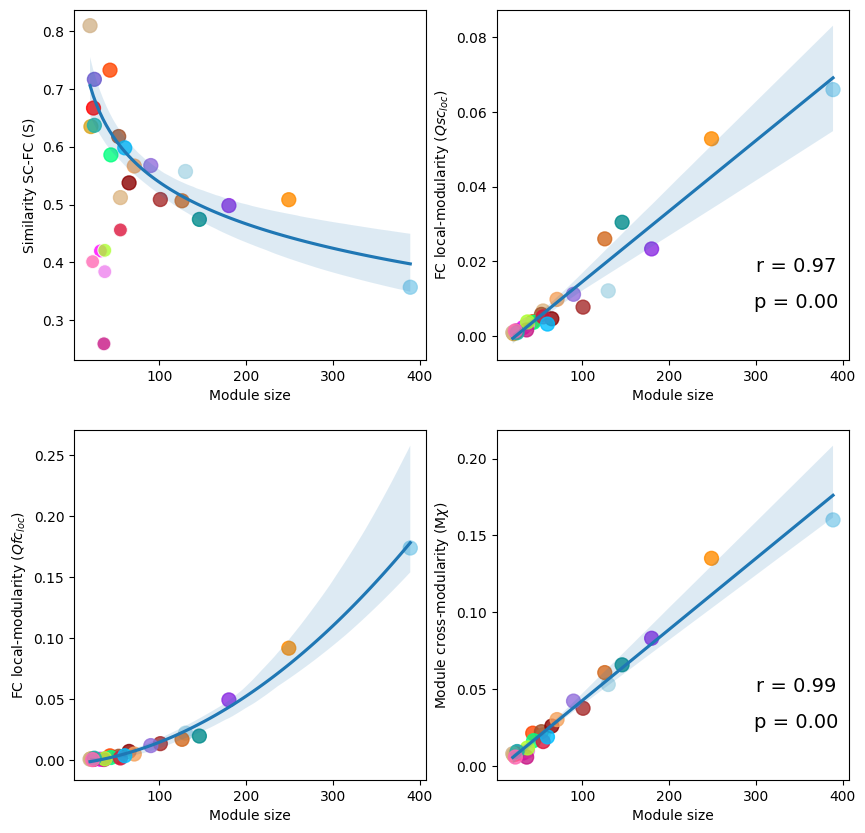

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# In the first plot, we saw some modules out of an exponential decay trend. So we remove them and plot again.
sim_trend_a = np.array(sim)[np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0].tolist()]
mod_size_sim_trend_a = np.array(mod_size)[np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0].tolist()]
colors_sim_trend_a = np.array(color_list_ni)[np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0].tolist()]
sim_trend_b = np.array(sim)[np.setdiff1d(np.arange(len(sim)), np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0])]
mod_size_sim_trend_b = np.array(mod_size)[np.setdiff1d(np.arange(len(sim)), np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0])]
colors_sim_trend_b = np.array(color_list_ni)[np.setdiff1d(np.arange(len(sim)), np.where((np.array(mod_size) < 100) & (np.array(sim) < 0.5))[0])]

sns.regplot(mod_size_sim_trend_b, sim_trend_b, logx=True, scatter_kws={'alpha':0.8, 's': 100, 'color': colors_sim_trend_b.tolist()}, ax=axes[0, 0])

sns.scatterplot(mod_size_sim_trend_a, sim_trend_a, alpha=0.8, s=100, c=colors_sim_trend_a.tolist(), ax=axes[0, 0])
axes[0, 0].set_xlabel("Module size")
axes[0, 0].set_ylabel("Similarity SC-FC (S)")

sns.regplot(mod_size, sc_localmod, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[0, 1])
axes[0, 1].set_xlabel("Module size")
axes[0, 1].set_ylabel("FC local-modularity (" + "$Qsc_{loc}$" + ")")
plot_corr(mod_size, sc_localmod, 0.85, 0.15, ax=axes[0, 1])

sns.regplot(mod_size, fc_localmod, order=2, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Module size")
axes[1, 0].set_ylabel("FC local-modularity (" + "$Qfc_{loc}$" + ")")

sns.regplot(mod_size, mxmod, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[1, 1])
axes[1, 1].set_xlabel("Module size")
axes[1, 1].set_ylabel("Module cross-modularity (M" + r"$\chi$" +")")
plot_corr(mod_size, mxmod, 0.85, 0.15, ax=axes[1, 1])


plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "module_xmod_measures.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)